In [2]:
import sys
import pylab as pl

In [3]:
import pymola
pymola.__version__
import pymola.parser
import pymola.backends.sympy.generator as gen_sympy

In [4]:
import sympy
import control
sympy.init_printing()
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Modelica Source Code

In [5]:
modelica_src = '''

model System
    input Real u;
    output Real x(start=1), v_x(start=1);
    Spring spring;
    Damper damper;
equation
    spring.x = x;
    damper.v = v_x;
    der(x) = v_x;
    der(v_x) = spring.f + damper.f - u;
end System;

model Spring
    Real x "displacement";
    Real f "force";
    parameter Real k = 2.0 "spring constant";
equation
    f = -k*x;
end Spring;

model Damper
    Real v "velocity";
    Real f "force";
    parameter Real c = 0.2 "damping constant";
equation
    f = -c*v;
end Damper;
'''

# Generation of Abstract Syntax Tree

In [6]:
ast = pymola.parser.parse(modelica_src)
ast.classes['System'].symbols.keys()

odict_keys(['u', 'x', 'v_x', 'spring', 'damper'])

# Generation of Sympy Model

In [7]:
src_code = gen_sympy.generate(ast, 'System')
print(src_code)


# do not edit, generated by pymola

from __future__ import print_function, division
import sympy
import sympy.physics.mechanics as mech
from pymola.backends.sympy.runtime import OdeModel
from sympy import sin, cos, tan


class System(OdeModel):

    def __init__(self):

        super(System, self).__init__()

        # states
        x, v_x = mech.dynamicsymbols('x, v_x')
        self.x = sympy.Matrix([x, v_x])
        self.x0 = {
            x : 1.0,
            v_x : 1.0,
            }

        # variables
        spring__x, spring__f, damper__v, damper__f = mech.dynamicsymbols('spring.x, spring.f, damper.v, damper.f')
        self.v = sympy.Matrix([spring__x, spring__f, damper__v, damper__f])

        # constants
        self.c = sympy.Matrix([])
        self.c0 = {
            }

        # parameters
        spring__k, damper__c = sympy.symbols('spring.k, damper.c')
        self.p = sympy.Matrix([spring__k, damper__c])
        self.p0 = {
            spring__k : 2.0,
            d

In [8]:
exec(src_code)
model = System()
model

{'t': t, 'x': Matrix([
[  x(t)],
[v_x(t)]]), 'u': Matrix([[u(t)]]), 'y': Matrix([
[  x(t)],
[v_x(t)]]), 'p': Matrix([
[spring.k],
[damper.c]]), 'c': Matrix(0, 0, []), 'v': Matrix([
[spring.x(t)],
[spring.f(t)],
[damper.v(t)],
[damper.f(t)]]), 'x0': {x(t): 1.0, v_x(t): 1.0}, 'u0': {u(t): 0}, 'p0': {spring.k: 2.0, damper.c: 0.2}, 'c0': {}, 'eqs': [spring.k*spring.x(t) + spring.f(t), damper.c*damper.v(t) + damper.f(t), spring.x(t) - x(t), damper.v(t) - v_x(t), -v_x(t) + Derivative(x(t), t), -damper.f(t) - spring.f(t) + u(t) + Derivative(v_x(t), t)], 'f': Matrix([
[                                 v_x(t)],
[-damper.c*v_x(t) - spring.k*x(t) - u(t)]]), 'g': Matrix([
[  x(t)],
[v_x(t)]])}

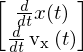

In [9]:
t = sympy.Symbol('t')
model.x.diff(t)

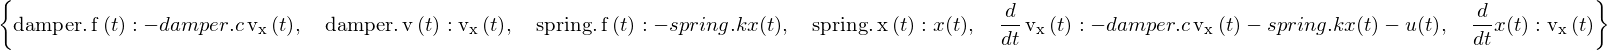

In [10]:
sol = sympy.solve(model.eqs, list(model.v) + list(model.x.diff(t)))
sol

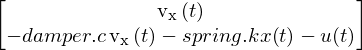

In [11]:
model.x.diff(t).subs(sol)

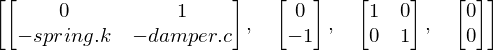

In [12]:
model.linearize_symbolic()

In [13]:
ss = control.ss(*model.linearize())
ss

A = [[ 0.   1. ]
 [-2.  -0.2]]

B = [[ 0.]
 [-1.]]

C = [[ 1.  0.]
 [ 0.  1.]]

D = [[ 0.]
 [ 0.]]

In [14]:
control.ss2tf(ss)


Input 1 to output 1:
      -1
---------------
s^2 + 0.2 s + 2

Input 1 to output 2:
      -s
---------------
s^2 + 0.2 s + 2

In [15]:
import warnings

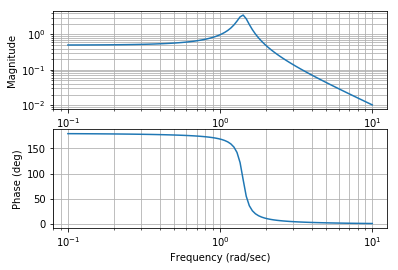

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    control.bode(ss[0,0], omega=pl.logspace(-1,1,100));

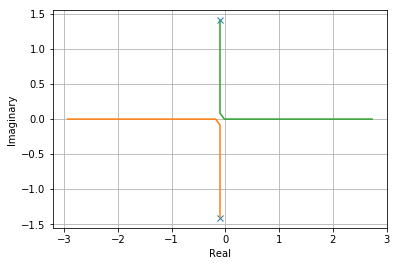

In [17]:
control.rlocus(ss[0,0], klist=pl.logspace(-2,1,1000));
pl.grid()

# Simulation of Sympy Model

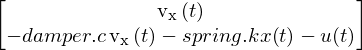

In [18]:
model.f

In [19]:
import sympy
ss_sub = {}
ss_sub.update({model.x[i]: sympy.DeferredVector('x')[i] for i in range(len(model.x))})
#ss_sub.update({model.y[i]: sympy.DeferredVector('y')[i] for i in range(len(model.y))})
ss_sub

In [20]:
res = model.simulate(t0=10, tf=20, dt=0.001)

Text(0,0.5,'x')

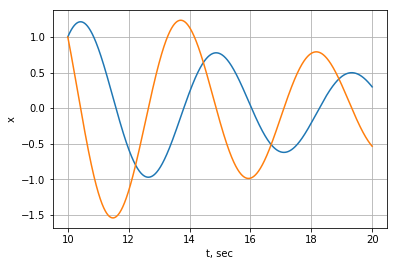

In [21]:
pl.plot(res['t'], res['x'])
pl.grid()
pl.xlabel('t, sec')
pl.ylabel('x')

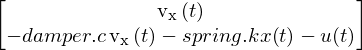

In [22]:
sympy.init_printing()
model.f

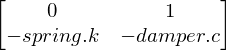

In [23]:
model.f.jacobian(model.x)

# Lyapunov Stability

Using the energy function as a candidate function, we can show that the system has global exponential stability (GES).

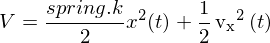

In [24]:
v_x, spring_k, t, V, x = sympy.symbols('v_x, spring.k, t, V, x')
V_eq = (v_x(t)**2 + spring_k*x(t)**2)/2
sympy.Eq(V, V_eq)

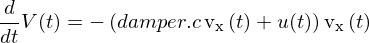

In [25]:
dV_dt_eq = (sympy.Matrix([V_eq]).jacobian(model.x).dot(model.f)).simplify()
sympy.Eq(V(t).diff(t), dV_dt_eq)

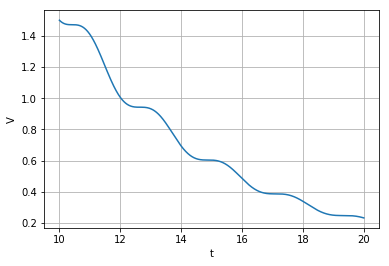

In [26]:
V_lam = sympy.lambdify(model.x, V_eq.subs(model.p0))
V_vals = [V_lam(*x) for x in res['x']]
pl.plot(res['t'], V_vals)
pl.xlabel('t')
pl.ylabel('V')
pl.grid()

# Parameter Sensitivity

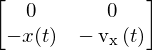

In [27]:
model.f.jacobian(model.p)